# Rede neural MLP como classificadora do dataset KMNIST

## Bibliotecas

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

## Importando o KMNIST

### Definindo a transformação no dataset

In [2]:
# Define a transformação para normalizar os dados
transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Batch size
batch_size = 120

In [3]:
# download e carrega os dados de treinamento
trainset = datasets.KMNIST('~/data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

# download e carrega os dados de validação/teste
testset = datasets.KMNIST('~/data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

Exemplar das imagens

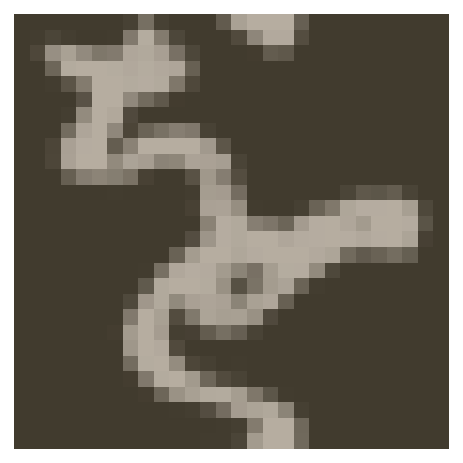

In [4]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Definindo os parâmetros da rede

In [5]:
# Model
model = fc_model.Network(784, 10, [196, 196, 49], 0.1)
# Learning rate
learning_rate = 0.1
# Optimizer
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
# Criterion
criterion = torch.nn.CrossEntropyLoss()
# Epoch
epochs = round(len(trainloader)/batch_size)

## Treinando

In [6]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs)

Epoch: 1/4..  Training Loss: 2.224..  Test Loss: 2.133..  Test Accuracy: 0.228
Epoch: 1/4..  Training Loss: 1.756..  Test Loss: 1.692..  Test Accuracy: 0.435
Epoch: 1/4..  Training Loss: 1.241..  Test Loss: 1.431..  Test Accuracy: 0.542
Epoch: 1/4..  Training Loss: 0.983..  Test Loss: 1.295..  Test Accuracy: 0.590
Epoch: 1/4..  Training Loss: 0.820..  Test Loss: 1.160..  Test Accuracy: 0.628
Epoch: 1/4..  Training Loss: 0.769..  Test Loss: 1.093..  Test Accuracy: 0.640
Epoch: 1/4..  Training Loss: 0.680..  Test Loss: 1.119..  Test Accuracy: 0.631
Epoch: 1/4..  Training Loss: 0.623..  Test Loss: 0.916..  Test Accuracy: 0.701
Epoch: 1/4..  Training Loss: 0.585..  Test Loss: 0.888..  Test Accuracy: 0.710
Epoch: 1/4..  Training Loss: 0.576..  Test Loss: 0.876..  Test Accuracy: 0.713
Epoch: 1/4..  Training Loss: 0.545..  Test Loss: 0.845..  Test Accuracy: 0.719
Epoch: 1/4..  Training Loss: 0.488..  Test Loss: 0.790..  Test Accuracy: 0.746
Epoch: 2/4..  Training Loss: 0.460..  Test Loss: 0.7

In [7]:
print("Nosso modelo: \n\n", model, '\n')
print("As chaves do dicionário: \n\n", model.state_dict().keys())

Nosso modelo: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=196, bias=True)
    (1): Linear(in_features=196, out_features=196, bias=True)
    (2): Linear(in_features=196, out_features=49, bias=True)
  )
  (output): Linear(in_features=49, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 

As chaves do dicionário: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


## Salvando e carregando o modelo

In [8]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [9]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [10]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=196, bias=True)
    (1): Linear(in_features=196, out_features=196, bias=True)
    (2): Linear(in_features=196, out_features=49, bias=True)
  )
  (output): Linear(in_features=49, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
